In [47]:
from sympy import *
from sympy.matrices import *
init_printing(use_latex=true)
import operator, functools
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib nbagg

In [103]:
t1,t2,t3,t4,t5,t6 = symbols("\\theta_1:7")
d1,d2,d3,d4,d5,d6 = symbols("d_1:7")
a1,a2,a3,a4,a5,a6 = symbols("a_1:7")
x,y,z,t = symbols('x,y,z,t')

def euler_angles(H):
    """ZYZ"""
    R = H[:3,:3]
    r33,r13,r23,r31,r32,r11,r12 = R[2,2],R[0,2],R[1,2],R[2,0],R[2,1],R[0,0],R[0,1]
    if r23!=0 and r13!=0:
        theta = atan2(sqrt(1-r33**2),r33)
        phi = atan2(r23,r13)
        psi = atan2(r32,-r31)
    elif r33==1:
        theta = 0
        phi = 0
        psi = atan2(-r12,r11)
    elif r33==-1:
        theta = pi
        psi = 0
        phi = atan2(-r12,-r11)
    else:
        theta = atan2(sqrt(1-r33**2),r33)
        phi = atan2(r23,r13)
        psi = atan2(r32,-r31)
    return phi.evalf(),theta.evalf(),psi.evalf()

def dhs(a,alpha,d,theta):
    M = Matrix([[cos(theta),-sin(theta)*cos(alpha),sin(theta)*sin(alpha),a*cos(theta)],
                  [sin(theta),cos(theta)*cos(alpha),-cos(theta)*sin(alpha),a*sin(theta)],
                  [0,sin(alpha),cos(alpha),d],
                  [0,0,0,1]])
    return M

class Manipulator(object):
    def __init__(self,*args):
        self.Ts = []
        self.type = []
        for k in args:
            self.Ts.append(dhs(k[0],k[1],k[2],k[3]))
            if len(k)>4:
                self.type.append(k[4])
            else:
                self.type.append('r')
        self.dof = len(args)
    
    def z(self,i):
        if i == 0: return Matrix([[0],[0],[1]])
        MTH = eye(4)
        for k in range(i):
            MTH = MTH*self.Ts[k]
        return MTH[:3,2]
    
    def p(self,i):
        if i == 0: return Matrix([[0],[0],[0]])
        MTH = eye(4)
        for k in range(i):
            MTH = MTH*self.Ts[k]
        return MTH[:3,3]
    
    @property
    def J(self):
        n = self.dof
        M_ = zeros(6,n)
        for i in range(self.dof):
            if self.type[i]=='r':
                jp = self.z(i).cross(self.p(n) - self.p(i))
                jo = self.z(i)
            else:
                jp = self.z(i)
                jo = zeros(3,1)
            jp = jp.col_join(jo)
            M_[:,i] = jp
        return simplify(M_)
    
    @property
    def T(self):
        return simplify(functools.reduce(operator.mul, self.Ts))
    
    def plot_diagram(self,vals):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        Ts = self.Ts
        T1_0 = Ts[0].subs(vals)
        T2_0 = (Ts[0]*Ts[1]).subs(vals)
        T3_0 = (T2_0*Ts[2]).subs(vals)
        T4_0 = (T3_0*Ts[3]).subs(vals)
        T5_0 = (T4_0*Ts[4]).subs(vals)
        T6_0 = (T5_0*Ts[5]).subs(vals)

        A = np.array([0,0,0])
        B = T1_0[:3,3]
        C = T2_0[:3,3]
        D = T3_0[:3,3]
        E = T4_0[:3,3]
        F = T5_0[:3,3]
        G = T6_0[:3,3]
        ax.plot([A[0],B[0],C[0],D[0],E[0],F[0],G[0]], 
                [A[1],B[1],C[1],D[1],E[1],F[1],G[1]], 
                [A[2],B[2],C[2],D[2],E[2],F[2],G[2]], '-o')
        self.draw_uvw(np.eye(4), ax)
        self.draw_uvw(T1_0, ax)
        self.draw_uvw(T2_0, ax)
        self.draw_uvw(T3_0, ax)
        self.draw_uvw(T4_0, ax)
        self.draw_uvw(T5_0, ax)
        self.draw_uvw(T6_0, ax)
        ax.set_xlim(-100,800)
        ax.set_ylim(-100,800)
        ax.set_zlim(-100,800)
    
    def draw_uvw(self,H,ax):
        u = H[:3,0]
        v = H[:3,1]
        w = H[:3,2]
        o = H[:3,3]
        ax.quiver(o[0],o[1],o[2],u[0],u[1],u[2],color="r", length=60)
        ax.quiver(o[0],o[1],o[2],v[0],v[1],v[2],color="g", length=60)
        ax.quiver(o[0],o[1],o[2],w[0],w[1],w[2],color="b", length=60)
        
def ea2mth(phi,theta,psi):
    return MTHR(phi)*MTHR(theta,"X")*MTHR(psi)

def MTHR(t,axis="z"):
    """
    Calcula la matriz de transformación homogénea correspondiente a una rotación 
    en cualesquiera de los ejes coordenados.
    """
    from sympy import sin,cos,tan
    if axis in ("z","Z",3):
        M = Matrix([[cos(t),-sin(t),0,0],
                  [sin(t),cos(t),0,0],
                  [0,0,1,0],
                  [0,0,0,1]])
    elif axis in ("y","Y",2):
        M = Matrix([[cos(t),0,sin(t),0],
                  [0,1,0,0],
                  [-sin(t),0,cos(t),0],
                  [0,0,0,1]])
    elif axis in ("x","X",1):
        M = Matrix([[1,0,0,0],
                  [0,cos(t),-sin(t),0,],
                  [0,sin(t),cos(t),0],
                  [0,0,0,1]])
    else:
        return eye(4)
    return M

deg = lambda x: (x*180/pi).evalf()
rad = lambda x: (x*pi/180).evalf()
radn = lambda x: (x*np.pi/180)

In [104]:
RRR = Manipulator((0,pi/2,d1,t1),(a2,0,-d2,t2),(a3,0,0,t3))
T = RRR.T
vals = {d1:100,d2:50,a2:200,a3:200}
T = T.subs(vals).evalf(chop=True)

In [105]:
#Fanuc.plot_diagram(vals)

## Inverse Kinematics

In [106]:
#vals = {t1:0,t2:pi/2,t3:0,t4:pi/3,t5:pi/3,t6:0}
#H = T.subs(vals).evalf()

In [107]:
d1,d2 =100,50
l2,l3 = 200,200
x,y,z = 300,100,200
rxy = sqrt(x**2 + y**2)
a = sqrt(rxy**2 - d2**2)
c = sqrt(z**2+a**2)
b = sqrt((z-d1)**2+a**2)
alpha = atan2(z-d1,a)
beta = acos((b**2+l2**2-l3**2)/(2*b*l2))
T2 = alpha - beta
T3 = acos((b**2-l2**2-l3**2)/(2*l2*l3))
T1 = atan2(a*y - d2*x, a*x + d2*y)

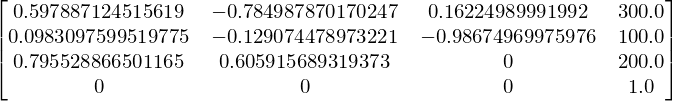

In [108]:
vals = {t1:T1,t2:T2,t3:T3}
T.subs(vals).evalf(chop=True)

<IPython.core.display.Javascript object>


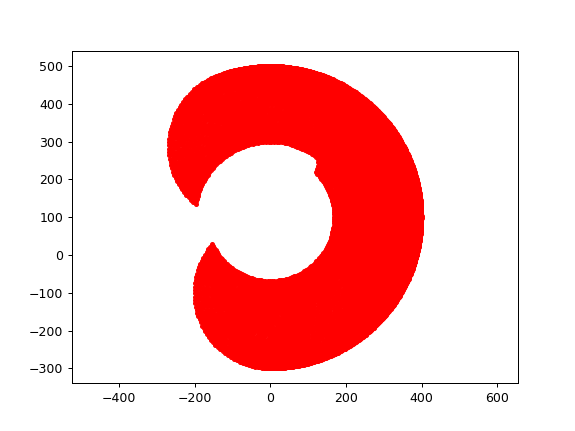

In [113]:
_t2,_t3 = np.linspace(-radn(90),radn(110),100), np.linspace(-radn(130),radn(120),100)
T2,T3 = np.meshgrid(_t2,_t3)
T1 = np.zeros_like(T2)
px = -50*np.sin(T1) + 200*np.cos(T1)*np.cos(T2) + 200*np.cos(T1)*np.cos(T2+T3)
pz = 200*np.sin(T2) + 200*np.sin(T2+T3) + 100
#for _t2 in np.linspace(-np.pi/2,np.pi/2,100):
#for _t3 in np.linspace(-np.pi/2,np.pi/2,100):
#TN = T.subs({t1:_t2,t2:_t2,t3:_t3})
#px,py,pz = TN[0,3], TN[1,3], TN[2,3]
plt.plot(px,pz,"r.")
plt.axis('equal')